# Part 4: Quantization

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

2025-03-10 18:22:37.656877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch the jet tagging dataset from Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [4]:
model = Sequential()
model.add(
    QDense(
        64,
        input_shape=(16,),
        name='fc1',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(
    QDense(
        5,
        name='output',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation='softmax', name='softmax'))

## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_3',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_3/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_3/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30


/home/minh/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


  1/487 [..............................] - ETA: 15:46 - loss: 1.7687 - accuracy: 0.2344WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0027s vs `on_train_batch_end` time: 0.0069s). Check your callbacks.


487/487 [==============================] - ETA: 0s - loss: 0.9734 - accuracy: 0.6798
***callbacks***
saving losses to model_3/losses.log

Epoch 1: val_loss improved from inf to 0.81227, saving model to model_3/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.81227, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_3/KERAS_check_model_last.h5

Epoch 1: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 4s 4ms/step - loss: 0.9734 - accuracy: 0.6798 - val_loss: 0.8123 - val_accuracy: 0.7372 - lr: 0.0010
Epoch 2/30
 42/487 [=>............................] - ETA: 1s - loss: 0.8023 - accuracy: 0.7395

/home/minh/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


472/487 [============================>.] - ETA: 0s - loss: 0.7817 - accuracy: 0.7455
***callbacks***
saving losses to model_3/losses.log

Epoch 2: val_loss improved from 0.81227 to 0.76602, saving model to model_3/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.81227 to 0.76602, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 2: saving model to model_3/KERAS_check_model_last.h5

Epoch 2: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.7813 - accuracy: 0.7456 - val_loss: 0.7660 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 3/30
479/487 [============================>.] - ETA: 0s - loss: 0.7530 - accuracy: 0.7532
***callbacks***
saving losses to model_3/losses.log

Epoch 3: val_loss improved from 0.76602 to 0.74854, saving model to model_3/KERAS_check_best_model.h5

Epoch 3: val_loss improved from 0.76602 to 0.74854, saving model to model_3/KERAS_check_best_model_weig


Epoch 14: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.7070 - accuracy: 0.7601 - val_loss: 0.7105 - val_accuracy: 0.7599 - lr: 0.0010
Epoch 15/30
480/487 [============================>.] - ETA: 0s - loss: 0.7059 - accuracy: 0.7604
***callbacks***
saving losses to model_3/losses.log

Epoch 15: val_loss did not improve from 0.71047

Epoch 15: val_loss did not improve from 0.71047

Epoch 15: saving model to model_3/KERAS_check_model_last.h5

Epoch 15: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.7057 - accuracy: 0.7606 - val_loss: 0.7109 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 16/30
480/487 [============================>.] - ETA: 0s - loss: 0.7049 - accuracy: 0.7609
***callbacks***
saving losses to model_3/losses.log

Epoch 16: val_loss did not improve from 0.71047

Epoch 16: val_loss did 


Epoch 28: val_loss improved from 0.70293 to 0.70239, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 28: saving model to model_3/KERAS_check_model_last.h5

Epoch 28: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.6981 - accuracy: 0.7630 - val_loss: 0.7024 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 29/30
480/487 [============================>.] - ETA: 0s - loss: 0.6978 - accuracy: 0.7633
***callbacks***
saving losses to model_3/losses.log

Epoch 29: val_loss did not improve from 0.70239

Epoch 29: val_loss did not improve from 0.70239

Epoch 29: saving model to model_3/KERAS_check_model_last.h5

Epoch 29: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.6979 - accuracy: 0.7632 - val_loss: 0.7061 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 30/30
483/487 [============================

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [8]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_3/hls4ml_prj', #part='xcu250-figd2104-2L-e'
    part='xc7z020clg400-1' # pynq-z1
)
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
np.save('model_3/y_qkeras.npy', y_qkeras)
np.save('model_3/y_hls.npy', y_hls)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:  

5188/5188 [==============================] - 3s 579us/step
Accuracy baseline:  0.7595060240963856
Accuracy pruned, quantized: 0.7598493975903614
Accuracy hls4ml: 0.7599638554216868


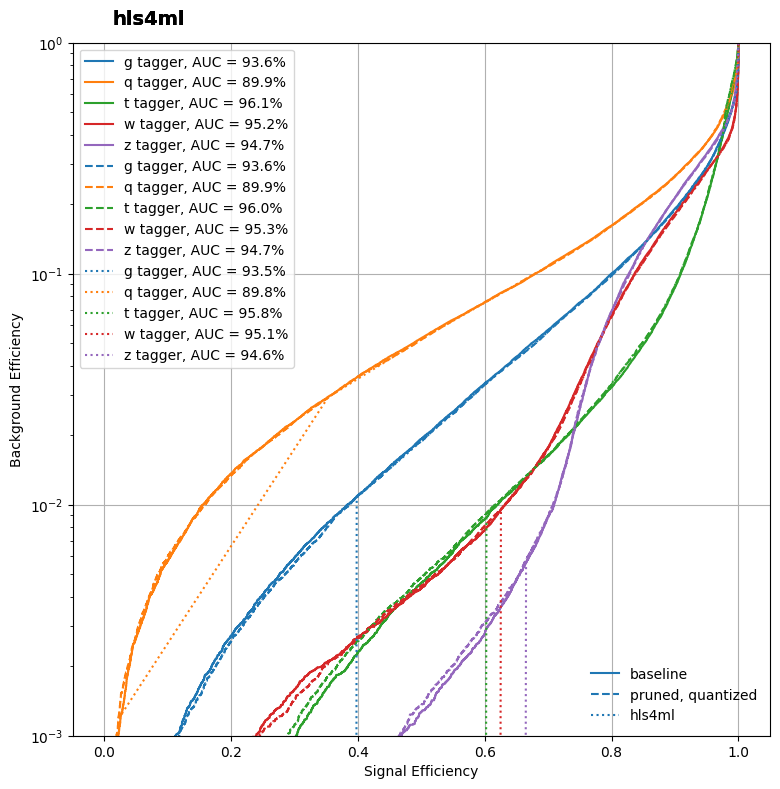

In [9]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj/vitis_hls.log`

In [10]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.2 (64-bit)
  **** SW Build 5238294 on Nov  8 2024
  **** IP Build 5239520 on Sun Nov 10 16:12:51 MST 2024
  **** SharedData Build 5239561 on Fri Nov 08 14:39:27 MST 2024
  **** Start of session at: Mon Mar 10 18:25:59 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis/2024.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'minh' on host 'minhLenovo' (Linux_x86_64 version 6.8.0-52-generic) on Mon Mar 10 18:26:01 EET 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/home/minh/Documents/UTU-Doctorate/control_theory/hls4ml-tutorial/model_3/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/home/minh/Documents/UTU-Doctorate/control_theory/hls4ml-tutorial

INFO: [HLS 200-1995] There were 14,227 instructions in the design after the 'Performance (step 1)' phase of compilation. See the Design Size Report for more details: /home/minh/Documents/UTU-Doctorate/control_theory/hls4ml-tutorial/model_3/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 14,035 instructions in the design after the 'Performance (step 2)' phase of compilation. See the Design Size Report for more details: /home/minh/Documents/UTU-Doctorate/control_theory/hls4ml-tutorial/model_3/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 13,841 instructions in the design after the 'Performance (step 3)' phase of compilation. See the Design Size Report for more details: /home/minh/Documents/UTU-Doctorate/control_theory/hls4ml-tutorial/model_3/hls4ml_prj/myproject_prj/solution1/syn/report/csynth_design_size.rpt
INFO: [HLS 200-1995] There were 13,841 instructions in the design after t

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 0.2 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.21 seconds; current allocated memory: 343.484 MB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 0.22 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.23 seconds; current allocated memory: 347.859 MB.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:39:102) in function 'nnet::relu<ap_fixed<27, 12, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, relu_config4>'... converting 241 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:39:102) in function 'nnet::relu<ap_fixed<19, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, relu_config7>'... converting 121 basic blocks.
INFO: [XFORM 203-401] Performing 

INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.72 seconds. CPU system time: 0.03 seconds. Elapsed time: 0.76 seconds; current allocated memory: 518.363 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.58 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.59 seconds; current allocated memory: 519.379 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_19_8_5_3_0_ap_ufixed_6_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining fun

INFO: [SCHED 204-61] Pipelining function 'myproject'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 53, function 'myproject'
Resolution: For help on HLS 200-871 see docs.xilinx.com/access/sources/dita/topic?Doc_Version=2024.2%20English&url=ug1448-hls-guidance&resourceid=200-871.html
	'call' operation 570 bit ('call_ret3', firmware/myproject.cpp:46) to 'dense_latency<ap_ufixed<6, 0, 4, 0, 0>, ap_fixed<19, 8, 5, 3, 0>, config5>' [146]  (4.699 ns)

Resolution: For help on HLS 200-1016 see docs.xilinx.com/access/sources/dita/topic?Doc_Version=2024.2%20English&url=ug1448-hls-guidance&resourceid=200-1016.html
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 0.08 seconds. CPU system time: 0 seconds. Elapsed time: 0.09 seconds; current allocated memory: 547.242 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Explo

INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'myproject' pipeline 'myproject' pipeline type 'function pipeline'
INFO: [RTGEN 206-104] Estimated max fanout for 'myproject' is 15477 from HDL expression: ((1'b1 == ap_CS_fsm_pp0_stage0) & (1'b0 == ap_block_pp0_stage0_11001_ignoreCallOp55))
INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 0.48 seconds. CPU system time: 0.02 seconds. Elapsed time: 0.52 seconds; current allocated memory: 800.711 MB.
INFO: [HLS 200-111] Finished Generating all RTL models: CPU user time: 0.55 seconds. CPU system time: 0.06 seconds. Elapsed time: 0.63 seconds; current allocated memory: 819.488 MB.
INFO: [HLS 200-111] Finished Updating report files: CPU user time: 0.93 seconds. CPU system time: 0.06 seconds. Elapsed time: 0.98 seconds; current allocated memory: 869.324 MB.
INFO: [VHDL 208-304] Generating VHDL RTL for myproject.
INFO: [VLOG 209-307] Generating Verilo

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.699',
  'BestLatency': '52',
  'WorstLatency': '52',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '38',
  'FF': '49457',
  'LUT': '51060',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [11]:
hls4ml.report.read_vivado_report('model_3/hls4ml_prj')

Found 1 solution(s) in model_3/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon Mar 10 18:27:18 2025

* Version:        2024.2 (Build 5238294 on Nov  8 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  4.699 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max   |    min   |    max   | min | max |   Type  |
    +---------+---------+----------+-------

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [12]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon Mar 10 17:51:09 2025

* Version:        2024.2 (Build 5238294 on Nov  8 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.648 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max   |    min   |    max   | min | max |   Type  |
    +---------+---------+----------+-------

Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vitis HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [13]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj')

Found 1 solution(s) in model_2/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon Mar 10 18:10:04 2025

* Version:        2024.2 (Build 5238294 on Nov  8 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.624 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max   |    min   |    max   | min | max |   Type  |
    +---------+---------+----------+-------

## NB
Note as well that the Vitis HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.